In [1]:
import sys
sys.path.append('./src/')

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()


In [2]:
def plot_single_serie(uid_df, ax):
    """
    uid_df: pandas df
    panel with columns unique_id, ds, y, split
    y_hat_df: pandas df
    panel with columns unique_id, ds, y_hat
    """
    # parse uid_df
    uid_df.reset_index(inplace=True)
    
    # plot last 60 observations
    sns.lineplot(x='ds', y='y', 
                 hue='split', data=uid_df[-60:], ax=ax) #, palette=['#FA6F94','#51DBE6']
    sns.lineplot(x='ds', y='Naive',
             color='#51DBE6', data=uid_df[-60:], ax=ax, label='Naive')
    sns.lineplot(x='ds', y='SeasonalNaive',
             color='#FA6F94', data=uid_df[-60:], ax=ax, label='SeasonalNaive')
    sns.lineplot(x='ds', y='Naive2',
             color='green', data=uid_df[-60:], ax=ax, label='Naive2')
    
    # rotate x axis
    ax.tick_params(axis='x', rotation=45)
    ax.tick_params(axis='y')
    ax.set_xlabel('Date Stamp')
    ax.set_ylabel('Value')
    
    # remove legend title
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles=handles[1:], labels=labels[1:])
    
    #sns.lineplot(x='ds', y='y', data=y_df, color='#FA6F94', label='Actual Data')
    #sns.lineplot(x='ds', y='y', data=y_hat_df, color='#51DBE6', label='Forecast Data', )
    #sns.set_style("dark")
    #plt.xlabel("Date Stamp", fontsize=14, color='#A2A2A2')
    #plt.ylabel("Value", fontsize=14, color='#A2A2A2')
    
def plot_grid_series(y, uids):
    assert len(uids)==8
    
    fig, axs = plt.subplots(2, 4, figsize=(20, 7))
    plt.subplots_adjust(wspace=0.35)
    plt.subplots_adjust(hspace=0.4)
    plt.xticks(rotation=45)

    for i, uid in enumerate(uids):
        # single plot parameters
        uid_df = y.loc[uid]
        #uid_df = y_df[y_df.unique_id==uid]
        row = int(np.round(i/8 + 0.001))
        col = i % 4
        
        plot_single_serie(uid_df, ax=axs[row, col])
    
    fig.tight_layout()
    plt.show()
    plot_file = "./results/grid_series.png"
    plt.savefig(plot_file, bbox_inches = "tight", dpi=300)
    plt.close()




Naive
SeasonalNaive
Naive2


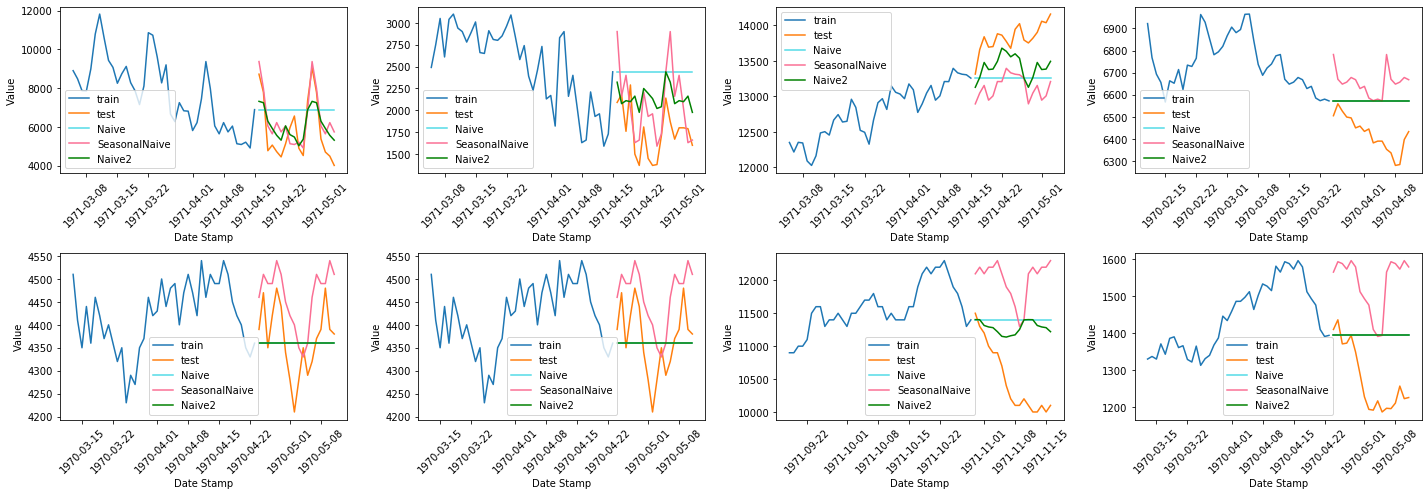

In [3]:
from src.benchmarks import *
from src.utils_data import M4_parser

seas_dict = {'Hourly': {'seasonality': 24, 'input_size': 24,
                       'output_size': 48},
             'Daily': {'seasonality': 7, 'input_size': 7,
                       'output_size': 14},
             'Weekly': {'seasonality': 52, 'input_size': 52,
                        'output_size': 13},
             'Monthly': {'seasonality': 12, 'input_size': 12,
                         'output_size':18},
             'Quarterly': {'seasonality': 4, 'input_size': 4,
                           'output_size': 8},
             'Yearly': {'seasonality': 1, 'input_size': 4,
                        'output_size': 6}}

def ml_pipeline(dataset_name, num_obs):
    # Read data
    X_train_df, y_train_df, X_test_df, y_test_df = M4_parser(dataset_name, num_obs)
    h = seas_dict[dataset_name]['output_size']
    seasonality = seas_dict[dataset_name]['seasonality']

    # Pre sort dataframes for efficiency
    X_train_df = X_train_df.set_index(['unique_id', 'ds']).sort_index()
    y_train_df = y_train_df.set_index(['unique_id', 'ds']).sort_index()
    X_test_df = X_test_df.set_index(['unique_id', 'ds']).sort_index()
    y_test_df = y_test_df.set_index(['unique_id', 'ds']).sort_index()
    
    # Train benchmark models
    models = {'Naive':  Naive(h=h),
              'SeasonalNaive': SeasonalNaive(h=h, seasonality=seasonality),
              'Naive2': Naive2(h=h, seasonality=seasonality)}
    
    preds = []
    for model_name, model in models.items():
        print(model_name)
        panel_model = PanelModel(model)
        panel_model.fit(X_train_df, y_train_df)
        mod_preds = panel_model.predict(X_test_df)
        mod_preds.name = model_name
        preds.append(mod_preds)
    preds = pd.concat(preds, axis=1)
    
    # Merge for visualization purpose
    y_train_df['split'] = 'train'
    y_test_df['split'] = 'test'
    y_df = y_train_df.append(y_test_df, sort=False)
    y_df = y_df.merge(preds, on=['unique_id','ds'], how='left')
    
    return y_df

# Grid Plot
y_df = ml_pipeline(dataset_name='Monthly', num_obs=10)

uids = ['M1', 'M2', 'M3', 'M4','M5', 'M5', 'M6', 'M8']
plot_grid_series(y_df, uids)

In [4]:
y_df

y  split   Naive  SeasonalNaive       Naive2
unique_id ds                                                           
M1        1970-01-02  8000.0  train     NaN            NaN          NaN
          1970-01-03  8350.0  train     NaN            NaN          NaN
          1970-01-04  8570.0  train     NaN            NaN          NaN
          1970-01-05  7700.0  train     NaN            NaN          NaN
          1970-01-06  7080.0  train     NaN            NaN          NaN
...                      ...    ...     ...            ...          ...
M9        1972-04-16  5130.0   test  5240.0         5440.0  5406.592727
          1972-04-17  5080.0   test  5240.0         5440.0  5369.121210
          1972-04-18  5100.0   test  5240.0         5460.0  5314.993436
          1972-04-19  5050.0   test  5240.0         5390.0  5164.917604
          1972-04-20  4860.0   test  5240.0         5240.0  4935.736796

[3859 rows x 5 columns]